# 客户画像复赛 数据处理

In [1]:
!ls Data_Update/train/

01_arc_s_95598_wkst_train.tsv  06_cont_info.tsv		11_c_meter.tsv
02_s_comm_rec.tsv	       07_c_rca_cons.tsv	12_a_pay_flow.tsv
03_s_info_oversee.tsv	       08_a_rcved_flow.tsv	out
04_c_cons.tsv		       09_arc_a_rcvbl_flow.tsv	train_label.csv
05_c_cons_prc.tsv	       10_c_meter_read.tsv


## 1 导入必要的包和函数

In [1]:
%pdb 1
debug = 1
import pandas as pd
import numpy as np
import pickle
import re
import io 
import matplotlib.pyplot as plt
%matplotlib inline

# 加载预定义好的函数
# 预定义好的函数：
#    - load_data(file_name, header=0): 加载数据
#    - def show_attribute_detail( data=None, attribute_name=None): 显示数据某个属性的详情
%run data_util_func.py
# 选择过滤方案
PLAN_TYPE = 3

Automatic pdb calling has been turned ON


In [3]:
# 训练集敏感用户 和待预测用户列表
# train_data_labels_df
# test_data_labels_df
# 代表工单数据
# train_data01_a_worker_per_user
# test_data01_a_worker_per_user
# 08表
# train_data08_merge_label_df
# test_data08_merge_label_df
%store -r train_data01_a_worker_per_user test_data01_a_worker_per_user
%store -r train_data_labels_df test_data_labels_df
%store -r train_data08_merge_label_df test_data08_merge_label_df

In [34]:
%who_ls

['FeatureEncoder',
 'data01_appno_contenttype_rdd',
 'data_feature_encoder',
 'debug',
 'extend_train_data',
 'get_accept_content_type',
 'get_highest_sensitive_workerid',
 'get_metrics',
 'io',
 'is_highest_sensitive_worker_dict',
 'load_data',
 'model_predict',
 'model_train',
 'np',
 'pd',
 'pickle',
 'plt',
 'print_function',
 're',
 'save_data',
 'seperate_data_to_classifier',
 'show_attribute_detail',
 'show_df_info',
 'test_data01_df',
 'test_data01_merge_label_df',
 'test_data_labels_df',
 'train_accept_content_type_count_df',
 'train_accept_content_type_sensitive_rate_series',
 'train_custno_in_season4_count_dict',
 'train_custno_in_season4_count_rdd',
 'train_custno_search_action_count_dict',
 'train_custno_search_action_count_rdd',
 'train_data01_a_worker_per_user',
 'train_data01_a_worker_per_user_accept_content_type_count_df',
 'train_data01_custno_handle_month_rdd',
 'train_data01_custno_issearchaction_rdd',
 'train_data01_merge_label_df',
 'train_data01_user_worker_count

In [36]:
del test_data_labels_df

##  2 加载数据 

### 2-4 08-实收电费信息表

#### 2-4-1 训练集 

##### 2-4-1-1 加载数据  train/08_a_rcved_flow.tsv

In [2]:
%%time
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
train_data08_df = load_data('Data_Update/train/08_a_rcved_flow.tsv', converters={'CONS_NO':unicode}) 

# 3,249,742 条记录
print(train_data08_df.shape)
# data08 中 总用户数为：  282,152
len(train_data08_df['CONS_NO'].unique())

(3249742, 9)
CPU times: user 4.76 s, sys: 324 ms, total: 5.08 s
Wall time: 5.31 s


In [73]:
show_df_info(train_data08_df)

    ORG_NO     CONS_NO  RCVED_YM  RCVED_DATE  THIS_RCVED_AMT  THIS_PENALTY  \
0  3340101  6011035199    201501    20150130      2143978.78           0.0   
1  3340101  1316023683    201501    20150128      2556221.39           0.0   
2  3340101  3190016243    201501    20150129      1607391.59           0.0   
3  3340101  6010496493    201501    20150107       153739.88           0.0   
4  3340101  1321072804    201501    20150107      3869548.04           0.0   

      OWE_AMT  RCVBL_YM  RCVBL_PENALTY  
0  2143978.78    201501            0.0  
1  2556221.39    201501            0.0  
2  1607391.59    201501            0.0  
3   153739.88    201501            0.0  
4  3869548.04    201501            0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3249742 entries, 0 to 3249741
Data columns (total 9 columns):
ORG_NO            int64
CONS_NO           object
RCVED_YM          int64
RCVED_DATE        int64
THIS_RCVED_AMT    float64
THIS_PENALTY      float64
OWE_AMT           float6

##### 2-4-1-2 将数据连接上标签 

In [4]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data08_merge_label_df = train_data08_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_NO',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data08_merge_label_df['TAG'] = train_data08_merge_label_df['TAG'].fillna(0)
train_data08_merge_label_df['TAG'] = train_data08_merge_label_df['TAG'].astype(int)

CPU times: user 2.1 s, sys: 40 ms, total: 2.14 s
Wall time: 2.14 s


In [5]:
%store train_data08_merge_label_df

Stored 'train_data08_merge_label_df' (DataFrame)


In [27]:
show_df_info(train_data08_merge_label_df)

    ORG_NO     CONS_NO  RCVED_YM  RCVED_DATE  THIS_RCVED_AMT  THIS_PENALTY  \
0  3340101  6011035199    201501    20150130      2143978.78           0.0   
1  3340101  1316023683    201501    20150128      2556221.39           0.0   
2  3340101  3190016243    201501    20150129      1607391.59           0.0   
3  3340101  6010496493    201501    20150107       153739.88           0.0   
4  3340101  1321072804    201501    20150107      3869548.04           0.0   

      OWE_AMT  RCVBL_YM  RCVBL_PENALTY     CUST_NO  TAG  
0  2143978.78    201501            0.0         NaN    0  
1  2556221.39    201501            0.0         NaN    0  
2  1607391.59    201501            0.0         NaN    0  
3   153739.88    201501            0.0  6010496493    1  
4  3869548.04    201501            0.0  1321072804    1  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3249742 entries, 0 to 3249741
Data columns (total 11 columns):
ORG_NO            int64
CONS_NO           object
RCVED_YM          int

###### 输出 训练集中 所有用户和标签，共 282,152个用户

In [33]:
train_data08_cust_no_tag_df = \
    train_data08_merge_label_df[['CONS_NO','TAG']].drop_duplicates().sort_values(by='TAG')
save_data(
    train_data08_cust_no_tag_df,
    'train_data08_cust_no_tag_df.csv'
)
train_data08_cust_no_tag_df.shape

(282152, 2)

###### 从文件中恢复

In [31]:
# 全部 CONS_NO 转为字符串，否则在连接表的时候会出问题
train_data08_cust_no_tag_df = load_data('train_data08_cust_no_tag_df.csv',
                                        encoding='utf8',
                                        converters={'CONS_NO':unicode}
                                       )



##### 2-4-1-3 统计敏感和不敏感的情况

###### 所有记录统计

(2,)


0    236493
1     45659
Name: TAG, dtype: int64

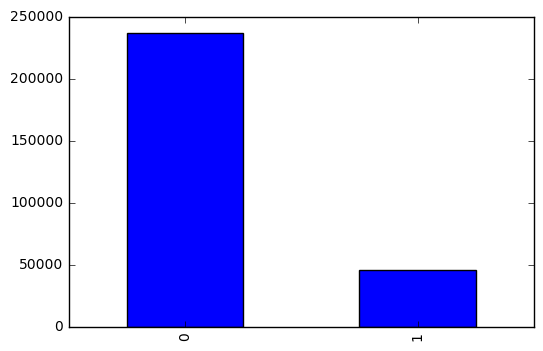

In [32]:
# 0    236,493
# 1     45,659
# 1/0 = 0.200263
show_attribute_detail(
    train_data08_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    'TAG'
)

###### 所有用户统计

(2,)


0    2707524
1     542218
Name: TAG, dtype: int64

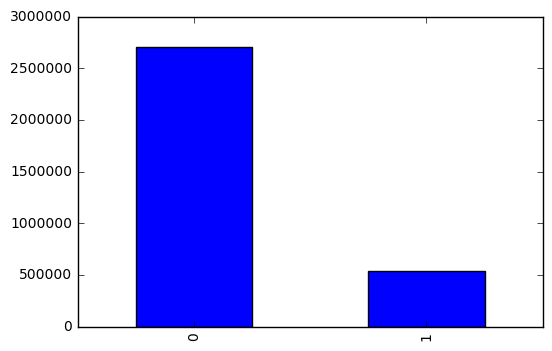

In [32]:
# 0    2,707,524
# 1     542,218
# 1/0 = 0.200263
show_attribute_detail(
    train_data08_merge_label_df,
    'TAG'
)

##### 和data01数据的用户列表比较

In [33]:
train_data01_data08_cust_no_tag_df = train_data01_cust_no_tag_df.merge(
    train_data08_cust_no_tag_df,
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 合并所有用户有：658374   ----  跟表1一样，即 表8和表9中所有用户都在表1中
# 在data01数据中，而不在data08数据中的用户数有：0
# 在data08数据中，而不在data01数据中的用户数有：376222
print '合并所有用户有：%d'%train_data01_data08_cust_no_tag_df.shape[0]
print '在data08数据中，而不在data01数据中的用户数有：%d'%sum(train_data01_data08_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data08数据中的用户数有：%d'%sum(train_data01_data08_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：658374
在data08数据中，而不在data01数据中的用户数有：0
在data01数据中，而不在data08数据中的用户数有：376222


(658374, 4)
(2,)
0    578349
1     80025
Name: TAG_x, dtype: int64
(376222, 4)
(2,)
0    341856
1     34366
Name: TAG_x, dtype: int64
(282152, 4)
(2,)
0    236493
1     45659
Name: TAG_x, dtype: int64


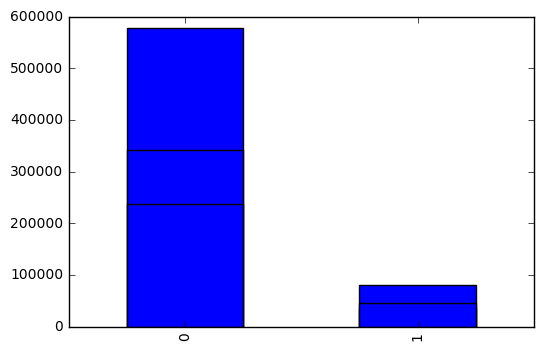

In [35]:
# 在data01数据中用户数有：658,374 ,其中不敏感有： 578,349，敏感有：80,025，1/0 比例为 0.1383680
print train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CUST_NO'].notnull()].shape
print show_attribute_detail(
    train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CUST_NO'].notnull()],
    'TAG_x'
)

# 在data01数据中，而不在data08数据中的用户数有：376,222,其中不敏感有： 341856，敏感有：34366，1/0 比例为 0.1005277
print train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CONS_NO'].isnull()].shape
print show_attribute_detail(
    train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CONS_NO'].isnull()],
    'TAG_x'
)
# 在data01数据中，也在data08数据中的用户数有：282,152,其中不敏感有： 236493，敏感有：45659，1/0 比例为 0.1930670252
print train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CONS_NO'].notnull()].shape
print show_attribute_detail(
    train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CONS_NO'].notnull()],
    'TAG_x'
)

#### 2-4-2 测试集 

##### 2-4-2-1 加载数据  test/08_a_rcved_flow_test.tsv

In [6]:
%%time
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
test_data08_df = load_data('Data_Update/test/08_a_rcved_flow_test.tsv',
                          converters={'CONS_NO':unicode}) 

# 3,710,654 条记录
print(test_data08_df.shape)
# data08 中 总用户数为：  311,222
len(test_data08_df['CONS_NO'].unique())

(3710654, 9)
CPU times: user 5.42 s, sys: 664 ms, total: 6.08 s
Wall time: 6.34 s


In [130]:
# 3,710,654 条记录
show_df_info(test_data08_df)

      CONS_NO   ORG_NO  RCVED_YM  RCVED_DATE  THIS_RCVED_AMT  THIS_PENALTY  \
0  6611825874  3340101    201501    20150113      1412988.62           0.0   
1  1321072599  3340101    201501    20150127    -16579561.98           0.0   
2  1321072599  3340101    201501    20150125       824632.00           0.0   
3  6611825874  3340101    201501    20150129      1755876.57           0.0   
4  1321072599  3340101    201501    20150114     16175368.00           0.0   

       OWE_AMT  RCVBL_YM  RCVBL_PENALTY  
0   1412988.62    201501            0.0  
1  17404193.98    201501            0.0  
2  17404193.98    201501            0.0  
3   1755876.57    201501            0.0  
4  16175368.00    201501            0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3710654 entries, 0 to 3710653
Data columns (total 9 columns):
CONS_NO           object
ORG_NO            int64
RCVED_YM          int64
RCVED_DATE        int64
THIS_RCVED_AMT    float64
THIS_PENALTY      float64
OWE_AMT           

###### 输出 测试集中 所有用户，共311,222个用户

In [18]:
test_data08_cust_no_df = \
    test_data08_df['CONS_NO'].drop_duplicates()
save_data(
    test_data08_cust_no_df,
    'test_data08_cust_no_df.csv'
)
test_data08_cust_no_df.shape

(311222,)

###### 从文件中恢复

In [19]:
test_data08_cust_no_df = load_data('test_data08_cust_no_df.csv',
                                   encoding='utf8',
                                   converters={'CONS_NO':unicode}
                                   )
# 全部转为字符串，否则在连接表的时候会出问题


##### 2-4-2-2 将数据连接上待预测用户列表

In [7]:
%%time
test_data08_merge_label_df = test_data08_df.merge(
    test_data_labels_df,
    left_on='CONS_NO',
    right_on='CUST_NO',
    how='left'
)

CPU times: user 2.36 s, sys: 252 ms, total: 2.61 s
Wall time: 2.61 s


In [9]:
test_data08_merge_label_df.shape

(3710654, 10)

In [10]:
%store test_data08_merge_label_df

Stored 'test_data08_merge_label_df' (DataFrame)


In [35]:
# 没在测试集中的数据有0,即全部都在测试集合
print sum(test_data08_merge_label_df['CUST_NO'].isnull())
# 总共用户数： 311222
print len(test_data08_merge_label_df['CONS_NO'].unique()) == 311222
# data01中用户 无 data08数据的 用户有 59,649
print 370871-len(test_data08_merge_label_df['CONS_NO'].unique())

NameError: name 'test_data08_merge_label_df' is not defined

> <ipython-input-35-a09d56ff09cf>(2)<module>()
      1 # 没在测试集中的数据有0,即全部都在测试集合
----> 2 print sum(test_data08_merge_label_df['CUST_NO'].isnull())
      3 # 总共用户数： 311222
      4 print len(test_data08_merge_label_df['CONS_NO'].unique()) == 311222
      5 # data01中用户 无 data08数据的 用户有 59,649

ipdb> q


#### 2-4-3 小结：
- 训练集有：3,249,742个实收电费信息数据
    - 不敏感：2,707,524;敏感：542,218,不敏感/敏感:0.200263
    - 将训练集客户编号提取并去重，发现训练集只有 282,152用户编号
           - 不敏感：236,493; 敏感：45,659, 不敏感/敏感:0.193067025
    - 与表1用户比较
        - 合并所有用户有：658374 (跟表1一样，即表8和表9中所有用户都在表1中)
        - 在data08数据中，而不在data01数据中的用户数有：0
        - 在data01数据中，而不在data08数据中的用户数有：376,222
        - 字段
            - ORG_NO            int64
            - CONS_NO           object
            - RCVED_YM          int64
            - RCVED_DATE        int64
            - THIS_RCVED_AMT    float64
            - THIS_PENALTY      float64
            - OWE_AMT           float64
            - RCVBL_YM          int64
            - RCVBL_PENALTY     float64
            
    - 在data01数据中用户数有：658,374 ,其中不敏感有： 578,349，敏感有：80,025，1/0 比例为 0.1383680
    - 在data01数据中，而不在data08数据中的用户数有：376,222,其中不敏感有： 341856，敏感有：34366，1/0 比例为 0.1005277
    - 在data01数据中，也在data08数据中的用户数有：282,152,其中不敏感有： 236493，敏感有：45659，1/0 比例为 0.1930670252
        - 连接上表的data01表用户的敏感度要高于连接不上表的
        
        
- 测试集有：  3,710,654个工单数据
- 将测试集客户编号提取并去重，发现训练集只有 311,222 用户编号，全部都在test_to_predict.csv（370871个用户）中，
    - 而 test_to_predict.csv 中有 59,649 个不在该表中


## 3 进行不同特征的探索

### 3-1 表1用户能否连接上08表

#### 3-13-1 训练集

In [33]:
%%time
temp = train_data01_a_worker_per_user.merge(
    train_data08_cust_no_tag_df,
    how='left',
    left_on='CUST_NO', 
    right_on='CONS_NO'
)
# 全部先设置 为 0
temp['IS_CONNECT_TO_08TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_08TABLE']=0


CPU times: user 968 ms, sys: 296 ms, total: 1.26 s
Wall time: 1.36 s


In [36]:
# 修改
train_data01_a_worker_per_user['IS_CONNECT_TO_08TABLE'] = temp['IS_CONNECT_TO_08TABLE']

In [38]:
sum(temp['CONS_NO'].isnull()) == 376222,sum(train_data01_a_worker_per_user['IS_CONNECT_TO_08TABLE']==0) == 376222

(True, True)

#### 3-13-2 测试集

In [39]:
%%time
temp = test_data01_a_worker_per_user.merge(
    test_data08_cust_no_df,
    how='left',
    left_on='CUST_NO', 
    right_on='CONS_NO'
)

# 全部先设置 为 0
temp['IS_CONNECT_TO_08TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_08TABLE']=0


CPU times: user 740 ms, sys: 16 ms, total: 756 ms
Wall time: 757 ms


In [43]:
# 修改
test_data01_a_worker_per_user['IS_CONNECT_TO_08TABLE'] = temp['IS_CONNECT_TO_08TABLE']

In [44]:
# 59649
sum(test_data01_a_worker_per_user['IS_CONNECT_TO_08TABLE']==0) 

59649

### 3-13 实收年月 RCVED_YM     

#### 3-13-1 训练集

(12, 5)
         total    tag0  tag0/total   tag1  tag1/total
201501  246178  206355    0.838235  39823    0.161765
201502  222141  187005    0.841830  35136    0.158170
201503  288639  238481    0.826226  50158    0.173774
201504  264855  220453    0.832354  44402    0.167646
201505  270376  224940    0.831953  45436    0.168047
201506  267961  223466    0.833950  44495    0.166050
201507  275888  229281    0.831066  46607    0.168934
201508  278303  232139    0.834123  46164    0.165877
201509  279637  233244    0.834096  46393    0.165904
201510  275274  229767    0.834685  45507    0.165315
201511  274438  229987    0.838029  44451    0.161971
201512  306052  252406    0.824716  53646    0.175284


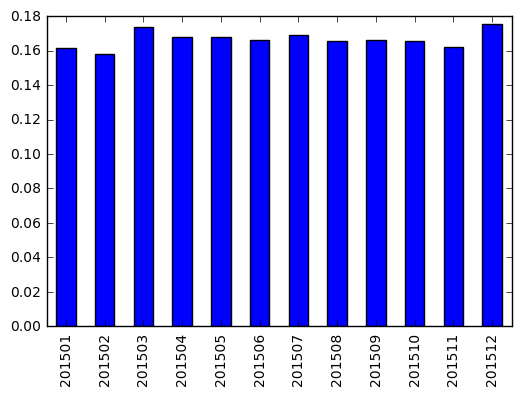

In [160]:
train_data08_merge_label_df_rcved_ym_count_df = show_attribute_detail(
    train_data08_merge_label_df,
    'RCVED_YM',
    split_by_tag=True, 
    tag_name='TAG', 
    show_pic=True
)
print train_data08_merge_label_df_rcved_ym_count_df

#### 3-13-2 测试集

(12,)
201501    291799
201502    266335
201503    325630
201504    305061
201505    308561
201506    306030
201507    311867
201508    316573
201509    318191
201510    312335
201511    312782
201512    335490
Name: RCVED_YM, dtype: int64


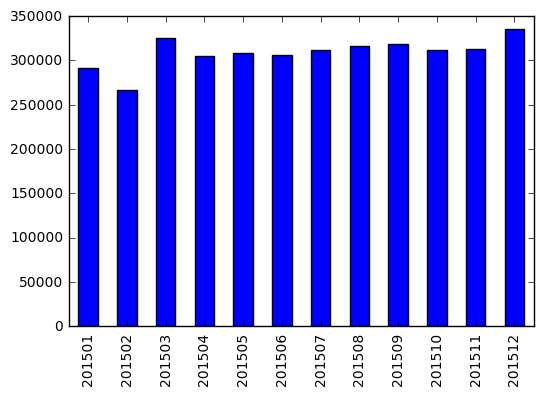

In [161]:
test_data08_merge_label_df_rcved_ym_count_df = show_attribute_detail(
    test_data08_merge_label_df,
    'RCVED_YM',
    show_pic=True
)
print test_data08_merge_label_df_rcved_ym_count_df

#### 3-13-3 小结
- 每个月份都差不多，无价值

### 3-14 8表 违约时间   RCVED_YM(实收日期) - RCVBL_YM(RCVBL_YM)

#### 3-13-1 训练集

In [17]:
train_data08_df[train_data08_df['CONS_NO']=='6010564379']

,ORG_NO,CONS_NO,RCVED_YM,RCVED_DATE,THIS_RCVED_AMT,THIS_PENALTY,OWE_AMT,RCVBL_YM,RCVBL_PENALTY,EXCEEDING_RCVBL_YM
414952,334010102,6010564379,201510,20151021,5.98,0.0,5.98,201504,0.0,6
414953,334010102,6010564379,201510,20151021,7.98,0.0,7.98,201502,0.0,8
1384722,33401011021,6010564379,201510,20151021,4.85,1.0,4.85,201509,0.1,1
1507535,33401011021,6010564379,201511,20151126,18.23,0.0,18.23,201511,0.0,0
1579476,33401011021,6010564379,201512,20151210,149.19,0.0,149.19,201512,0.0,0


##### 超出 应收时间的月数  EXCEEDING_RCVBL_YM

In [6]:
train_data08_df['EXCEEDING_RCVBL_YM'] = train_data08_df['RCVED_YM']-train_data08_df['RCVBL_YM']

In [24]:
%%time
# 统计是否有 违约1个月以上
train_data08_cons_no_exceeding_rcvbl_ge1_series = \
    train_data08_df.groupby('CONS_NO')['EXCEEDING_RCVBL_YM'].apply(lambda x : int(sum(x>1)>0))

CPU times: user 53.3 s, sys: 208 ms, total: 53.5 s
Wall time: 53.3 s


In [25]:
train_data08_cons_no_exceeding_rcvbl_ge1_series.head()

CONS_NO
0002471802    0
0002471815    0
0002476706    1
0002506278    0
0002557351    0
Name: EXCEEDING_RCVBL_YM, dtype: int64

In [ ]:
train_data01_

In [22]:
train_data08_df[train_data08_df['EXCEEDING_RCVBL_YM']>2].head()

,ORG_NO,CONS_NO,RCVED_YM,RCVED_DATE,THIS_RCVED_AMT,THIS_PENALTY,OWE_AMT,RCVBL_YM,RCVBL_PENALTY,EXCEEDING_RCVBL_YM
833,3340101,1321042853,201510,20151016,-315203.64,-49171.77,315203.64,201507,-49171.77,3
834,3340101,1321042853,201510,20151016,-510247.01,-67352.61,510247.01,201507,-67352.61,3
835,3340101,1321042853,201510,20151016,315203.64,55475.84,315203.64,201507,55475.84,3
836,3340101,1321042853,201510,20151016,285868.50,43452.02,510247.01,201507,43452.01,3
837,3340101,1321042853,201510,20151006,315203.64,49171.77,315203.64,201507,49171.77,3


##### 是否违约超过一个月 ----添加到 train_data01_a_worker_per_user中

In [26]:
# 是否违约超过一个月
train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data08_cons_no_exceeding_rcvbl_ge1_series)


In [17]:
# 连接不上的用户 设置为2
train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'] = \
    train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'].fillna(2)

In [29]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON']>0].iloc[0]

APP_NO                                        2015101280034874
ID                                            1000000527323992
BUSI_TYPE_CODE                                               3
URBAN_RURAL_FLAG                                             1
ORG_NO                                                   33401
HANDLE_TIME                                 2015/10/12 9:25:31
ACCEPT_CONTENT                               【查询电费】客户查询电费，已告知。
HANDLE_OPINION                                             NaN
CALLING_NO                                         1.71473e+06
ELEC_TYPE                                                  202
CUST_NO                                             6010564379
PROV_ORG_NO                                              33101
CITY_ORG_NO                                              33401
TAG                                                          0
NUM_OF_WORKER                                                1
ACCEPT_CONTENT_TYPE                                    

(2,)


0    9155
1    4112
Name: TAG, dtype: int64

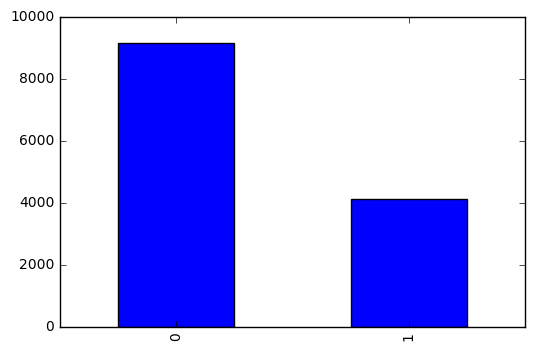

In [20]:
show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON']>0],
    'TAG'
)

#### 3-13-1 测试集

##### 超出 应收时间的月数  EXCEEDING_RCVBL_YM

In [31]:
test_data08_df['EXCEEDING_RCVBL_YM'] = test_data08_df['RCVED_YM']-test_data08_df['RCVBL_YM']

In [32]:
%%time
# 统计是否有 违约1个月以上
test_data08_cons_no_exceeding_rcvbl_ge1_series = \
    test_data08_df.groupby('CONS_NO')['EXCEEDING_RCVBL_YM'].apply(lambda x : int(sum(x>1)>0))

CPU times: user 54.1 s, sys: 284 ms, total: 54.4 s
Wall time: 54.2 s


In [33]:
test_data08_cons_no_exceeding_rcvbl_ge1_series.head()

CONS_NO
0002460938    0
0002506210    0
0002581691    0
0002581910    0
0002582157    0
Name: EXCEEDING_RCVBL_YM, dtype: int64

In [34]:
test_data08_df[test_data08_df['EXCEEDING_RCVBL_YM']>2].head()

,CONS_NO,ORG_NO,RCVED_YM,RCVED_DATE,THIS_RCVED_AMT,THIS_PENALTY,OWE_AMT,RCVBL_YM,RCVBL_PENALTY,EXCEEDING_RCVBL_YM
22958,6023006132,334010101,201504,20150401,37.02,2.18,37.02,201501,2.18,3
22989,6023181182,334010101,201504,20150402,76.93,4.62,76.93,201501,4.62,3
23057,6023116123,334010101,201504,20150401,186.14,10.98,186.14,201501,10.98,3
23066,6023132626,334010101,201504,20150401,68.29,4.03,68.29,201501,4.03,3
23110,6011056875,334010101,201504,20150401,76.62,4.52,76.62,201501,4.52,3


##### 是否违约超过一个月 ----添加到 train_data01_a_worker_per_user中

In [35]:
# 是否违约超过一个月
test_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data08_cons_no_exceeding_rcvbl_ge1_series)


In [18]:
# 连接不上的用户 设置为2
test_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'] = \
    test_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'].fillna(2)

In [38]:
test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON']>0].shape

(6081, 47)

### 3-14 本次实收电费 THIS_RCVED_AMT     

#### 3-13-1 训练集

In [12]:
train_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN,NaN,0
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN,NaN,0
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN,NaN,0
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN,NaN,0
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN,NaN,0


In [130]:
%%time
train_data08_merge_label_this_reved_amt_sum_df = \
    train_data08_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['THIS_RCVED_AMT'].sum()

CPU times: user 2.84 s, sys: 748 ms, total: 3.58 s
Wall time: 4.58 s


In [130]:
%%time
train_data08_merge_label_this_reved_amt_sum_df = \
    train_data08_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['THIS_PENALTY'].sum()

CPU times: user 2.84 s, sys: 748 ms, total: 3.58 s
Wall time: 4.58 s


In [125]:
%%time
train_data09_merge_label_reved_amt_sum_df = \
    train_data09_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['RCVED_AMT'].sum()

CPU times: user 5.29 s, sys: 2.43 s, total: 7.72 s
Wall time: 10.6 s


In [125]:
%%time
train_data09_merge_label_reved_amt_sum_df = \
    train_data09_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['RCVED_PENALTY'].sum()

CPU times: user 5.29 s, sys: 2.43 s, total: 7.72 s
Wall time: 10.6 s


In [131]:
print train_data08_merge_label_this_reved_amt_sum_df.head()
print train_data09_merge_label_reved_amt_sum_df.head()

      CONS_NO  RCVBL_YM  THIS_RCVED_AMT
0  1081380222    201502          201.75
1  1100506263    201505           16.50
2  1100506385    201501           55.10
3  1100507494    201509           19.92
4  1100508075    201503           60.79
      CONS_NO  RCVBL_YM   RCVED_AMT
0  1000101001    201501  5301415.41
1  1000101001    201502  4372080.02
2  1000101001    201503  4829490.74
3  1000101001    201504  5375305.81
4  1000101001    201505  5294991.89


In [ ]:
train_data08_reved_amt_sum_df = pd.DataFrame(train_data08_merge_label_this_reved_amt_sum_df)
train_data09_reved_amt_sum_df = pd.DataFrame(train_data09_merge_label_reved_amt_sum_df)
print train_data08_reved_amt_sum_df.head()
print train_data09_reved_amt_sum_df.head()
# print train_data08_reved_amt_sum_df[u'1100565675']
save_data(
    train_data08_reved_amt_sum_df.merge(
        train_data09_merge_label_reved_amt_sum_df,
        how='outer',
        on=['CONS_NO','RCVBL_YM']),
    'temp.csv',
)

      CONS_NO  RCVBL_YM  THIS_RCVED_AMT
0  1081380222    201502          201.75
1  1100506263    201505           16.50
2  1100506385    201501           55.10
3  1100507494    201509           19.92
4  1100508075    201503           60.79
      CONS_NO  RCVBL_YM   RCVED_AMT
0  1000101001    201501  5301415.41
1  1000101001    201502  4372080.02
2  1000101001    201503  4829490.74
3  1000101001    201504  5375305.81
4  1000101001    201505  5294991.89


In [37]:
train_data09_merge_label_reved_amt_sum_df.head()

CONS_NO
1000101001    66434070.00
1000104008         143.10
1000108003      995971.48
1000108017     4749925.38
1000108020     5873519.25
Name: RCVED_AMT, dtype: float64

In [27]:
train_data08_merge_label_this_reved_amt_sum_df.head()

CONS_NO
1081380222    201.75
1100506263     16.50
1100506385     55.10
1100507494     19.92
1100508075     60.79
Name: THIS_RCVED_AMT, dtype: float64

In [39]:
train_data09_merge_label_reved_amt_sum_df.shape,train_data08_merge_label_this_reved_amt_sum_df.shape

((555748,), (282152,))

In [25]:
%%time
train_data08_merge_label_this_penalty_sum_df = \
    train_data08_merge_label_df.groupby(by='CONS_NO')['THIS_PENALTY'].sum()

CPU times: user 1.42 s, sys: 180 ms, total: 1.6 s
Wall time: 1.6 s


In [26]:
train_data08_merge_label_this_penalty_sum_df.head()

CONS_NO
1081380222    1.0
1100506263    0.0
1100506385    0.0
1100507494    0.0
1100508075    0.0
Name: THIS_PENALTY, dtype: float64